In [124]:
import ngsolve as ngs
from ngsolve.webgui import Draw
import numpy as np
import matplotlib.pyplot as plt

mesh = ngs.Mesh('proximity_geo.vol')
mesh.Curve(2)
# mesh.RefineHP(3,factor = 0.2)
mesh.Refine()
mesh.Refine()

In [125]:
# Parameters

# circ_mass = np.pi*0.031**2
# circ_number = 58

mu0 = 1.256*1e-6
mu_iron = 1*mu0
sigma = 58*1e6
Js = 1e7
eps = 1e-10
order = 2

circles_left = ""; 
for i in range(58): circles_left+="circle_left_"+str(i)+"|"
circles_right = ""; 
for i in range(58): circles_right+="circle_right_"+str(i)+"|"

cf_Js = mesh.MaterialCF({circles_left: Js, circles_right: -Js}, default = 0)
cf_mu = mesh.MaterialCF({ circles_left + circles_right + "left|right|bridge" : mu0, "ambient": mu_iron})
cf_sigma = mesh.MaterialCF({circles_left + circles_right: sigma}, default = 0)

#############################################################################################################

f = 0 #(Hz)
w = f*2*np.pi

H1 = ngs.H1(mesh, order = order, dirichlet = "ambient_face", complex = True)
PH1 = ngs.H1(mesh, order = 0, definedon = circles_left + circles_right, complex = True)
# PH1 = ngs.H1(mesh, order = order, dirichlet = "circle_edge", complex = True, definedon = circles_left + circles_right)

X = H1*PH1

# u,v = X.TnT()
(A,L), (As,Ls) = X.TnT()

K = ngs.BilinearForm(X)
K += (1/cf_mu*ngs.grad(A)*ngs.grad(As))*ngs.dx +((1j*w)*cf_sigma*(A)*As + cf_sigma*(L)*As)*ngs.dx(circles_left + circles_right)\
    +((1j*w)*cf_sigma*(A)*Ls + cf_sigma*(L)*Ls + 1/eps*ngs.grad(L)*ngs.grad(Ls))*ngs.dx(circles_left + circles_right)
K.Assemble()

# rows,cols,vals = K.mat.COO()
# import scipy.sparse as sp
# A = sp.csr_matrix((vals,(rows,cols)))
# plt.spy(A, markersize = 1)

# volCopper = ngs.Integrate(ngs.CF(1.0)*ngs.dx(circles_left + circles_right), mesh)/58/2

f = ngs.LinearForm(X)
f += (cf_Js*Ls)*ngs.dx(circles_left + circles_right)
f.Assemble()


A_and_L = ngs.GridFunction(X)
A_and_L.vec.data += K.mat.Inverse(X.FreeDofs())*f.vec

A = A_and_L.components[0]
L = A_and_L.components[1]
B = ngs.grad(A)

tot_J = (1j*w)*cf_sigma*(A) + cf_sigma*(L)


# # J = J/intJ*I

In [126]:
# Draw(ngs.log(ngs.Norm(tot_J)), mesh, settings = {"Objects": {"Wireframe": False}})
Draw(ngs.Norm(tot_J), mesh, settings = {"Objects": {"Wireframe": False}})
# Draw(ngs.log(ngs.Norm(L)), mesh, settings = {"Objects": {"Wireframe": False}})
# Draw(ngs.log(ngs.Norm(J)), mesh, settings = {"Objects": {"Wireframe": False}})
# Draw(ngs.log(ngs.Norm(B)), mesh, settings = {"Objects": {"Wireframe": False}})
# Draw((J), mesh, settings = {"Objects": {"Wireframe": False}})
# Draw((J), mesh, settings = {"Objects": {"Wireframe": False}}, animate_complex = True)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

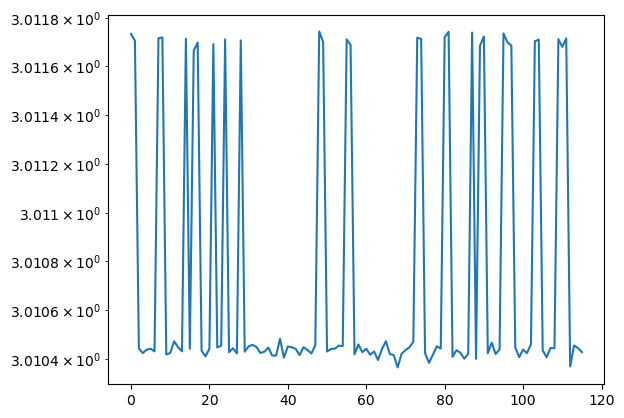

In [127]:
int = []
for i in range(58):
    int.append(ngs.Integrate(tot_J*ngs.dx("circle_left_"+str(i)), mesh))
for i in range(58):
    int.append(ngs.Integrate(tot_J*ngs.dx("circle_right_"+str(i)), mesh))
# mesh.nv

plt.semilogy(abs(np.real(int)))
plt.semilogy(abs(np.imag(int)))

# ngs.Integrate(1/eps*ngs.grad(L)*ngs.grad(A), mesh)

In [128]:
ngs.Integrate(1/sigma*ngs.Norm(tot_J)*ngs.Norm(tot_J), mesh)

60.21508419235505

In [129]:
print(np.array(X.FreeDofs()).shape)
print(np.where(np.array(X.FreeDofs()))[0].shape)

(321294,)
(282527,)


In [130]:
ngs.Integrate(ngs.Norm(tot_J)*ngs.dx(circles_left + circles_right),mesh)

349.24728223082377

In [131]:
vJ = ngs.Integrate(ngs.Norm(tot_J)*ngs.dx(circles_left + circles_right),mesh)
volCopper = ngs.Integrate(ngs.CF(1.0)*ngs.dx(circles_left + circles_right), mesh)
print(volCopper, vJ, vJ*volCopper)

3.492470761654772e-05 349.24728223082377 0.012197359217785442


In [132]:
L2 = ngs.L2(mesh, complex = True)
a = ngs.GridFunction(L2)
a.Set(tot_J)
print(max(a.vec.FV().real),max(a.vec.FV().imag))
print(min(a.vec.FV().real),min(a.vec.FV().imag))

10000161.272984331 0.0
-10000144.421685634 0.0
